## Data Simulation

In [170]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle
sys.path.append('/Users/khalilouardini/Desktop/projects/scVI/scvi')
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### import ete3 Tree

In [171]:
#from ete3 import Tree
#import ete3

#tree_name = "/Users/khalilouardini/Desktop/projects/scVI/scvi/data/Cassiopeia_trees/3726_NT_T1_tree.processed.collapsed.tree"

#with open(tree_name, "r") as myfile:
    #tree_string = myfile.readlines()
    #tree = Tree(tree_string[0], 1)

#tree = Tree(tree_name, 1)
#for i, n in enumerate(tree.traverse('levelorder')):
    #n.add_features(index=i)

In [226]:
tree_file = "/Users/khalilouardini/Desktop/projects/scVI/scvi/data/1000cells/no_fitness/topology20.pkl"

with open(tree_file, 'rb') as f:
    graph = pickle.load(f)

# adding branch length attribute to the leaves
for n in graph.nodes(data=True):
    if type(n[0]) == int:
        n[1]['branch_length'] = 0
    else:
        n[1]['branch_length'] = n[0].branch_length
        
def networkx_to_ete3(graph, root):
    subtrees = {node[0]: ete3.Tree(name=node[0], dist=node[1]['branch_length']) for node in graph.nodes(data=True)}
    [*map(lambda edge: subtrees[edge[0]].add_child(subtrees[edge[1]]), graph.edges())]
    tree = subtrees[root]
    return tree

root = [n for n, d in graph.in_degree() if d==0] [0]
tree = networkx_to_ete3(graph, root)

branch_lengths = {}
node_names = []

for i, n in enumerate(tree.traverse('levelorder')):
    n.add_features(index=i)
    n.name = str(i)
    node_names.append(str(i))
    branch_lengths[n.name] = n.dist

In [173]:
os.chdir('/Users/khalilouardini/Desktop/projects/scVI/')

import numpy as np
import pandas as pd
from anndata import AnnData
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from dataset.tree import TreeDataset, GeneExpressionDataset
from dataset.poisson_glm import Poisson_GLM
from dataset.anndataset import AnnDatasetFromAnnData
from models import *;
import scanpy as sc
from inference.tree_inference import TreeTrainer
from inference.inference import UnsupervisedTrainer
from inference import posterior
from models.treevae import TreeVAE
from utils.data_util import get_leaves, get_internal
from utils.metrics import ks_pvalue, accuracy_imputation, correlations
from utils.plots_util import plot_histograms, plot_scatter_mean, plot_ecdf_ks
from utils.baselines import avg_weighted_baseline, scvi_baseline
import torch
from ete3 import Tree
import seaborn as sns

import logging

#os.chdir('/Users/khalilouardini/Desktop/projects/scVI/scvi/notebooks')

### Simulate latent space + Count Data

In [174]:
d = 5
g = 100
vis = True
leaves_only = False
var = 1.0

glm = Poisson_GLM(tree, g, d, vis, leaves_only, var)
glm.simulate_latent()

Generate gene expression count data (GLM Poisson)

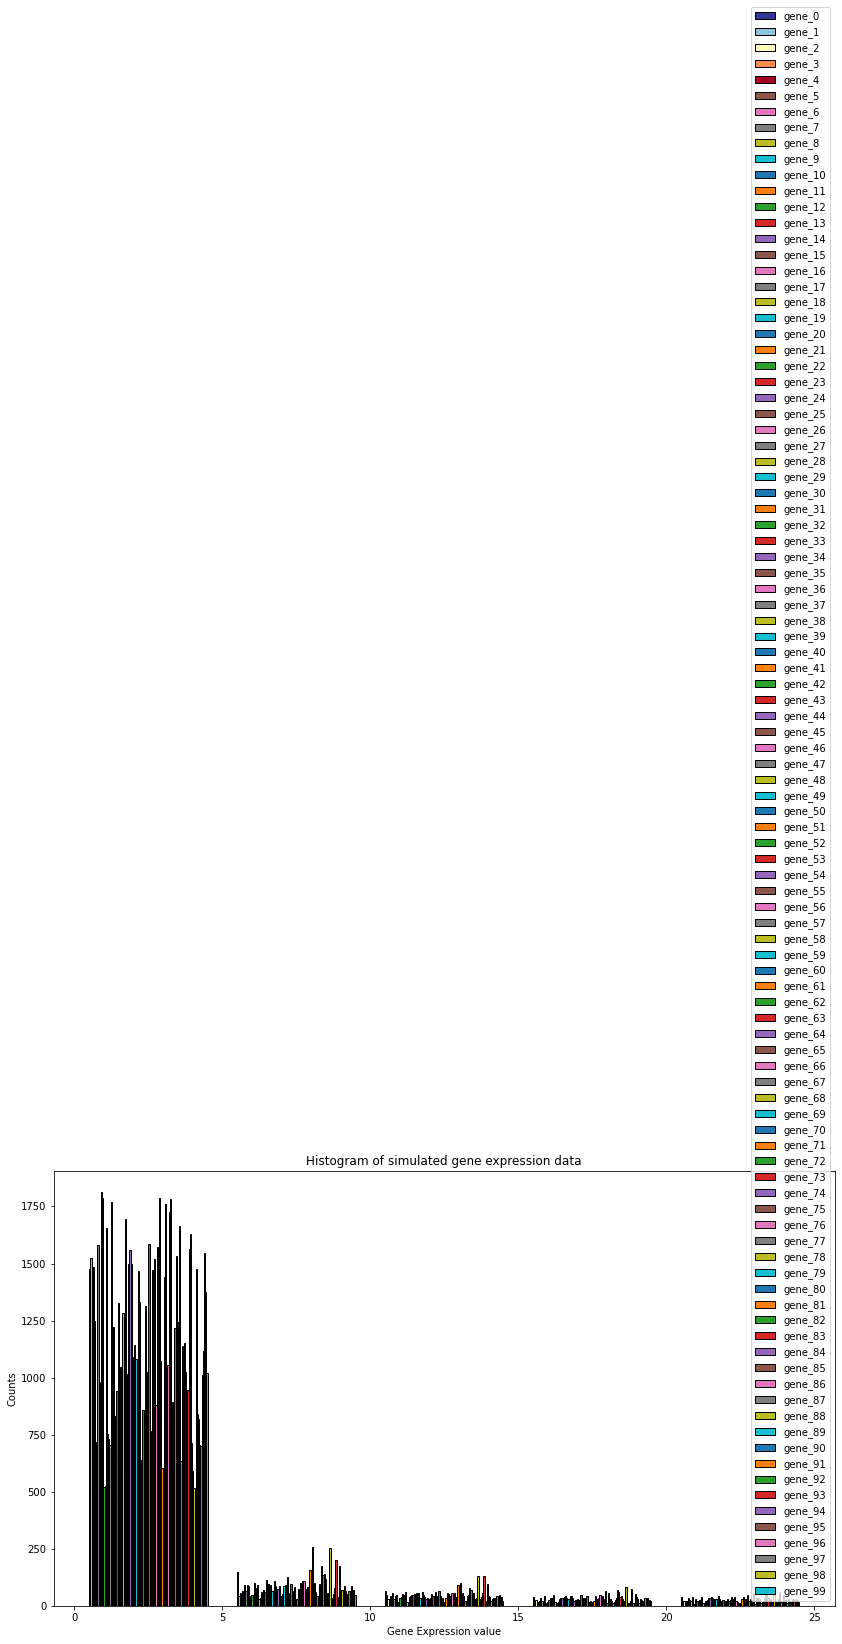

In [175]:
glm.simulate_ge()

In [176]:
leaves_z, _, _ = get_leaves(glm.z, glm.mu, tree)
leaves_z.shape

(1000, 5)

****Gene Filtering + Normalization****

In [177]:
glm.gene_qc()
glm.X.shape, glm.mu.shape

((1999, 100), (1999, 100))

Get leaf data + index

In [189]:
#FIXED training set
leaves_X, leaves_idx, mu = get_leaves(glm.X, glm.mu, tree)

# internal nodes data (for imputation)
internal_X, internal_idx, internal_mu = get_internal(glm.X, glm.mu, tree)

leaves_X.shape, mu.shape, internal_X.shape, internal_mu.shape

((1000, 100), (1000, 100), (999, 100), (999, 100))

Generate multiple samples for statistical tests

In [184]:
#g2 = glm.X.shape[1]
#glm2 = Poisson_GLM(tree_name, g2, d, False, leaves_only, branch_length)

#glm_samples = glm2.generate(n_samples=2,
#                          leaves_idx=leaves_idx,
#                           )

#glm_samples.shape

## Cassiopeia + scVI

Create csv files with all cells barcodes

Create Gene Expression tree Dataset

In [185]:
import scanpy as sc
# anndata
adata = AnnData(leaves_X)
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)
#sc.pp.normalize_total(adata, target_sum=1e4)

In [186]:
scvi_dataset = AnnDatasetFromAnnData(adata)
adata.obs_names = [n.name for n in list(tree.get_leaves())]
scvi_dataset.initialize_cell_attribute('barcodes', adata.obs_names)

[2021-01-25 10:38:55,011] WARNING - scvi.dataset.dataset | n_counts is a protected attribute or already exists as a cell attribute and cannot be set with this name in initialize_gene_attribute, changing name to n_counts_gene and setting
[2021-01-25 10:38:55,011] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-01-25 10:38:55,012] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-01-25 10:38:55,016] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-01-25 10:38:55,017] INFO - scvi.dataset.dataset | Downsampled from 1000 to 1000 cells


Cassiopeia + gene expression dataset

In [187]:
# treeVAE
cas_dataset = TreeDataset(scvi_dataset, tree)
cas_dataset

[2021-01-25 10:38:59,438] INFO - scvi.dataset.dataset | Merging datasets. Input objects are modified in place.
[2021-01-25 10:38:59,438] INFO - scvi.dataset.dataset | Gene names and cell measurement names are assumed to have a non-null intersection between datasets.
[2021-01-25 10:38:59,439] INFO - scvi.dataset.dataset | Keeping 100 genes
[2021-01-25 10:38:59,442] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-01-25 10:38:59,443] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-01-25 10:38:59,444] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-01-25 10:38:59,445] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-01-25 10:38:59,446] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-01-25 10:38:59,449] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-01-25 10:38:59,450] INFO - scvi.dataset.dataset | Downsampled from 1000 to 1000 cells


GeneExpressionDataset object with n_cells x nb_genes = 1000 x 100
    gene_attribute_names: 'gene_names', 'n_counts_gene'
    cell_attribute_names: 'labels', 'local_vars', 'local_means', 'barcodes', 'n_counts', 'batch_indices'
    cell_categorical_attribute_names: 'labels', 'batch_indices'

## Training the model

Hyperparamaters

In [190]:
n_epochs = 1000
lr = 1e-3
# No batches beacause of the message passing
use_batches = False
use_cuda = False

In [191]:
vae = TreeVAE(cas_dataset.nb_genes,
              tree = cas_dataset.tree,
              n_batch=cas_dataset.n_batches * use_batches,
              n_latent=glm.latent,
              n_hidden=128,
              n_layers=1,
              reconstruction_loss='poisson',
              prior_t = None,
             )
freq = 10
trainer = TreeTrainer(
    model = vae,
    gene_dataset = cas_dataset,
    train_size=1.0,
    test_size=0,
    use_cuda=use_cuda,
    frequency=freq,
    n_epochs_kl_warmup=None
)

train_leaves:  [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112], [113], [114], [115], [116], [117], [118], [119], [120], [121], [122], [123], [124], [125], [126], [127], [128], [129], [130], [131], [132], [133], [134], [135], [136], [137], [138], [139], [140], [141], [142], [143], [144], [145], [146], [147], [148], [149], [150], [151], [152], [153], [154], [155], [1

Training the model

In [192]:
trainer.train(n_epochs=n_epochs,
              lr=lr)

computing elbo
ELBO Loss: 3862164.504224818
training:   1%|          | 9/1000 [00:01<03:19,  4.96it/s]computing elbo
ELBO Loss: 2687889.842302328
training:   2%|▏         | 19/1000 [00:03<02:58,  5.49it/s]computing elbo
ELBO Loss: 2526724.8295662217
training:   3%|▎         | 29/1000 [00:05<03:00,  5.37it/s]computing elbo
ELBO Loss: 2004614.382457973
training:   4%|▍         | 39/1000 [00:07<03:01,  5.30it/s]computing elbo
ELBO Loss: 1738850.160954964
training:   5%|▍         | 49/1000 [00:09<02:54,  5.45it/s]computing elbo
ELBO Loss: 1499291.7435292176
training:   6%|▌         | 59/1000 [00:11<02:58,  5.27it/s]computing elbo
ELBO Loss: 1242171.3065272125
training:   7%|▋         | 69/1000 [00:13<03:05,  5.01it/s]computing elbo
ELBO Loss: 1097101.1103256624
training:   8%|▊         | 79/1000 [00:16<03:05,  4.97it/s]computing elbo
ELBO Loss: 1008002.2130736877
training:   9%|▉         | 89/1000 [00:18<03:00,  5.06it/s]computing elbo
ELBO Loss: 916732.5895647154
training:  10%|▉         

#### Visualizing the loss: training

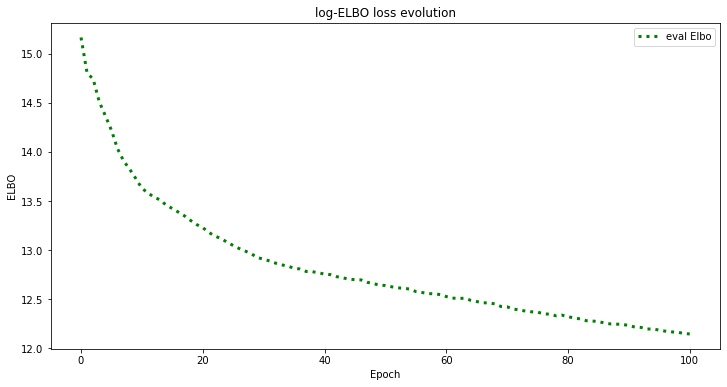

In [197]:
figure = plt.figure(figsize=(12,6))

elbo_train_set = trainer.history["elbo_train_set"]
epochs = np.linspace(start=0, 
                     stop=n_epochs,
                     num=int(n_epochs/freq),
                    dtype=int)
plt.plot(
         np.log(elbo_train_set),
         label="eval Elbo",
         color='green',
         linestyle=':',
         linewidth=3
         )

#plt.plot(np.log(trainer.history_train['elbo']),
         #label="train Elbo",
         #color='red',
         #linestyle=':',
         #linewidth=3.0
         #)

plt.xlabel('Epoch')
plt.ylabel('ELBO')
plt.legend()
plt.title("log-ELBO loss evolution")
plt.show()

Visualuazing the loss terms separateley

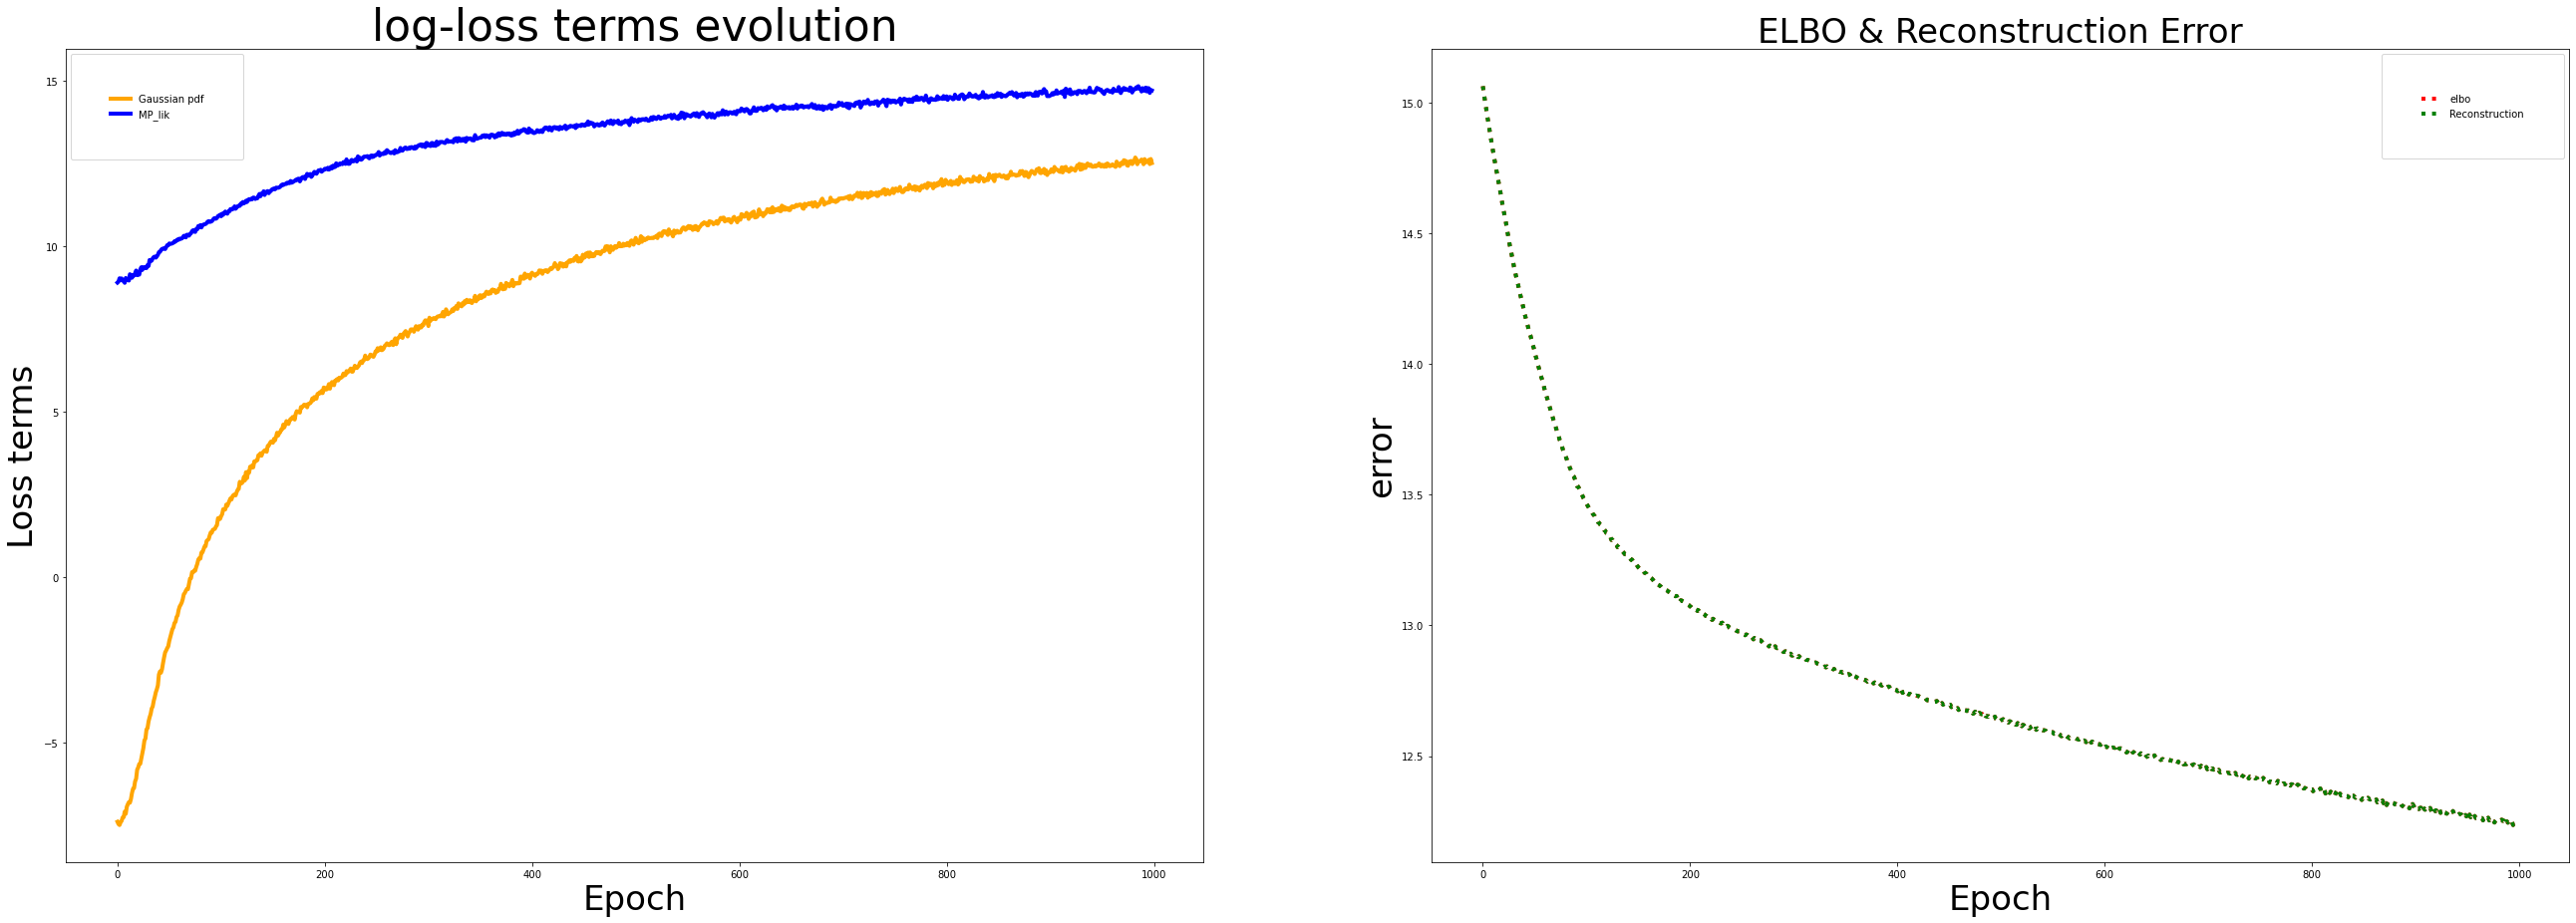

In [198]:
figure, (ax1, ax2) = plt.subplots(figsize=(45, 15), ncols=2)

ax1.plot(trainer.history_train['Gaussian pdf'][1:],
         label="Gaussian pdf",
         color='orange',
         linewidth=4.0
         )

ax1.plot(trainer.history_train['MP_lik'][1:],
         label="-1 * MP Likelihood",
         color='blue',
         linewidth=4.0
         )

ax2.plot(np.log(trainer.history_train['elbo'][1:]),
         label="elbo",
         color='red',
         linestyle=':',
         linewidth=4.0
         )

ax2.plot(np.log(trainer.history_train['Reconstruction'][1:]),
         label="Reconstruction error",
         color='green',
         linestyle=':',
         linewidth=4.0
         )

ax2.set_title('ELBO & Reconstruction Error', fontsize=34)
ax2.set_xlabel('Epoch', fontsize=34)
ax2.set_ylabel('error', fontsize=34)
ax2.legend(list(trainer.history_train.keys())[:2], loc='best', borderpad=4)

ax1.set_xlabel('Epoch', fontsize=34)
ax1.set_ylabel('Loss terms', fontsize=34)
ax1.set_title("log-loss terms evolution", fontsize=44)
ax1.legend(list(trainer.history_train.keys())[2:][::-1], loc='best', borderpad=4)

plt.show()

Reconstruction - KL ratio loss

Text(0, 0.5, 'Ratio')

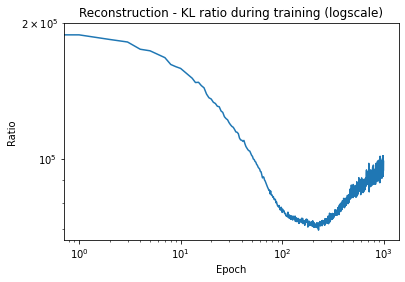

In [199]:
plt.plot([x / (z - y) for x, (y,z) in zip(trainer.history_train['Reconstruction'][5:], zip(trainer.history_train['Gaussian pdf'][5:], trainer.history_train['MP_lik'][5:]))])
plt.loglog()
plt.title("Reconstruction - KL ratio during training (logscale)")
plt.xlabel("Epoch")
plt.ylabel("Ratio")

Evolution of encoder's variance

Text(0, 0.5, 'Frobenius Norm of Variance')

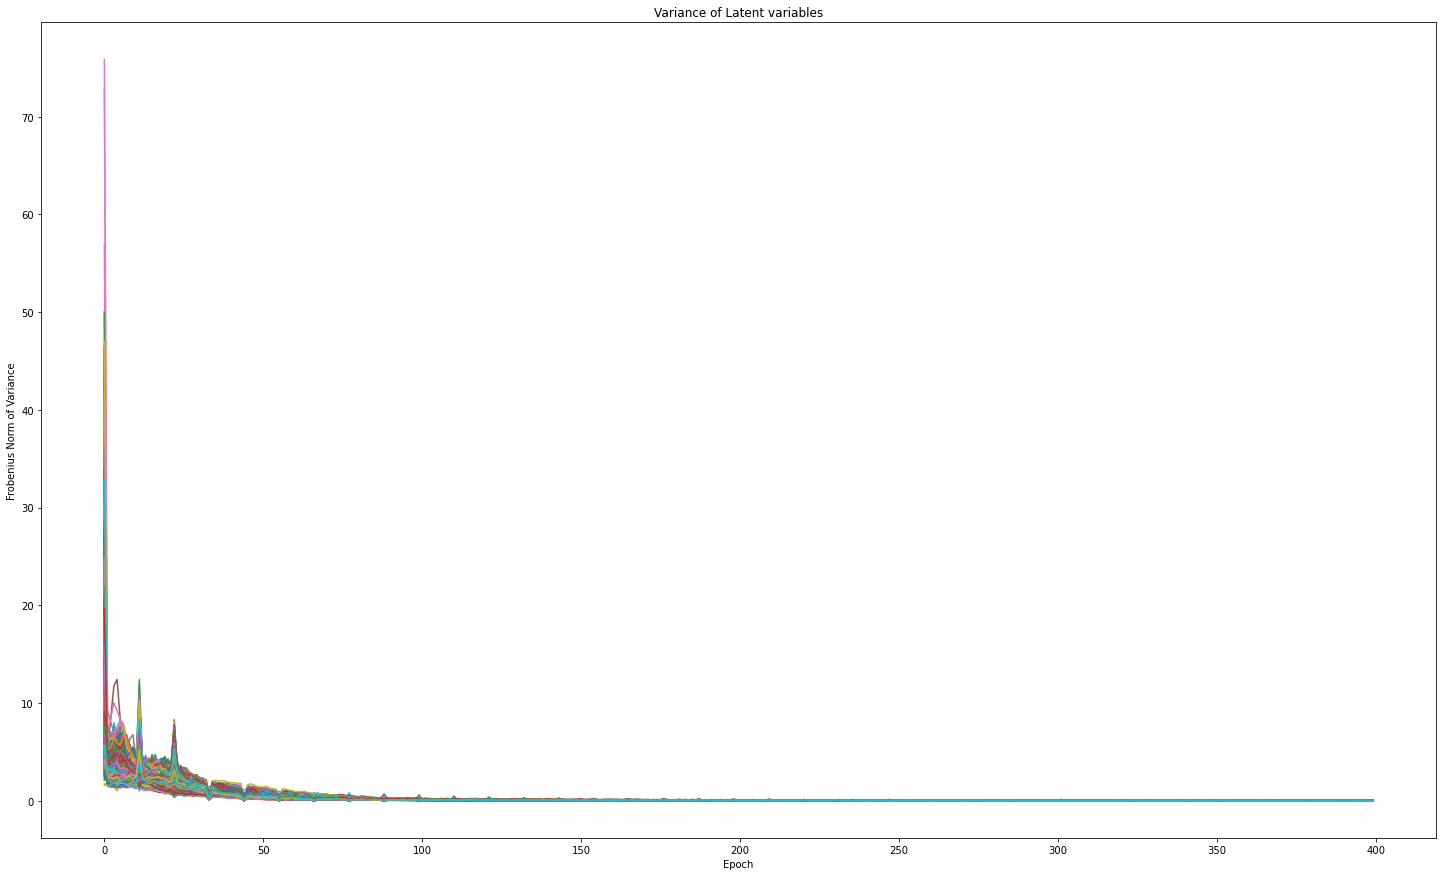

In [200]:
figure = plt.subplots(figsize=(25, 15))

plt.plot(vae.encoder_variance[:400])
plt.title("Variance of Latent variables")
plt.xlabel("Epoch")
plt.ylabel("Frobenius Norm of Variance")

## Inference and Posterior Predictive Checks (PPC)

### PPC 0: Mean parameters test
The idea is to compare the mean of the poisson of the simulated data to the inferred mean from scVI, by computing a distance (L1 or L2 norm)

In [201]:
full_posterior = trainer.create_posterior(trainer.model, cas_dataset, trainer.clades,
                                indices=np.arange(len(cas_dataset)))

In [202]:
from sklearn.metrics import mean_squared_error

# imputation (NB mean)
imputed_values = full_posterior.sequential().imputation_mean(n_samples=1)

# RMSE (Mean of Poisson GLM) - (Mean of Negative Binomial)
rmse = mean_squared_error(mu, imputed_values)
print("the distance between the Poisson and the NB means is {}".format(rmse))

the distance between the Poisson and the NB means is 250755513.18271515


Plots to explore correlations

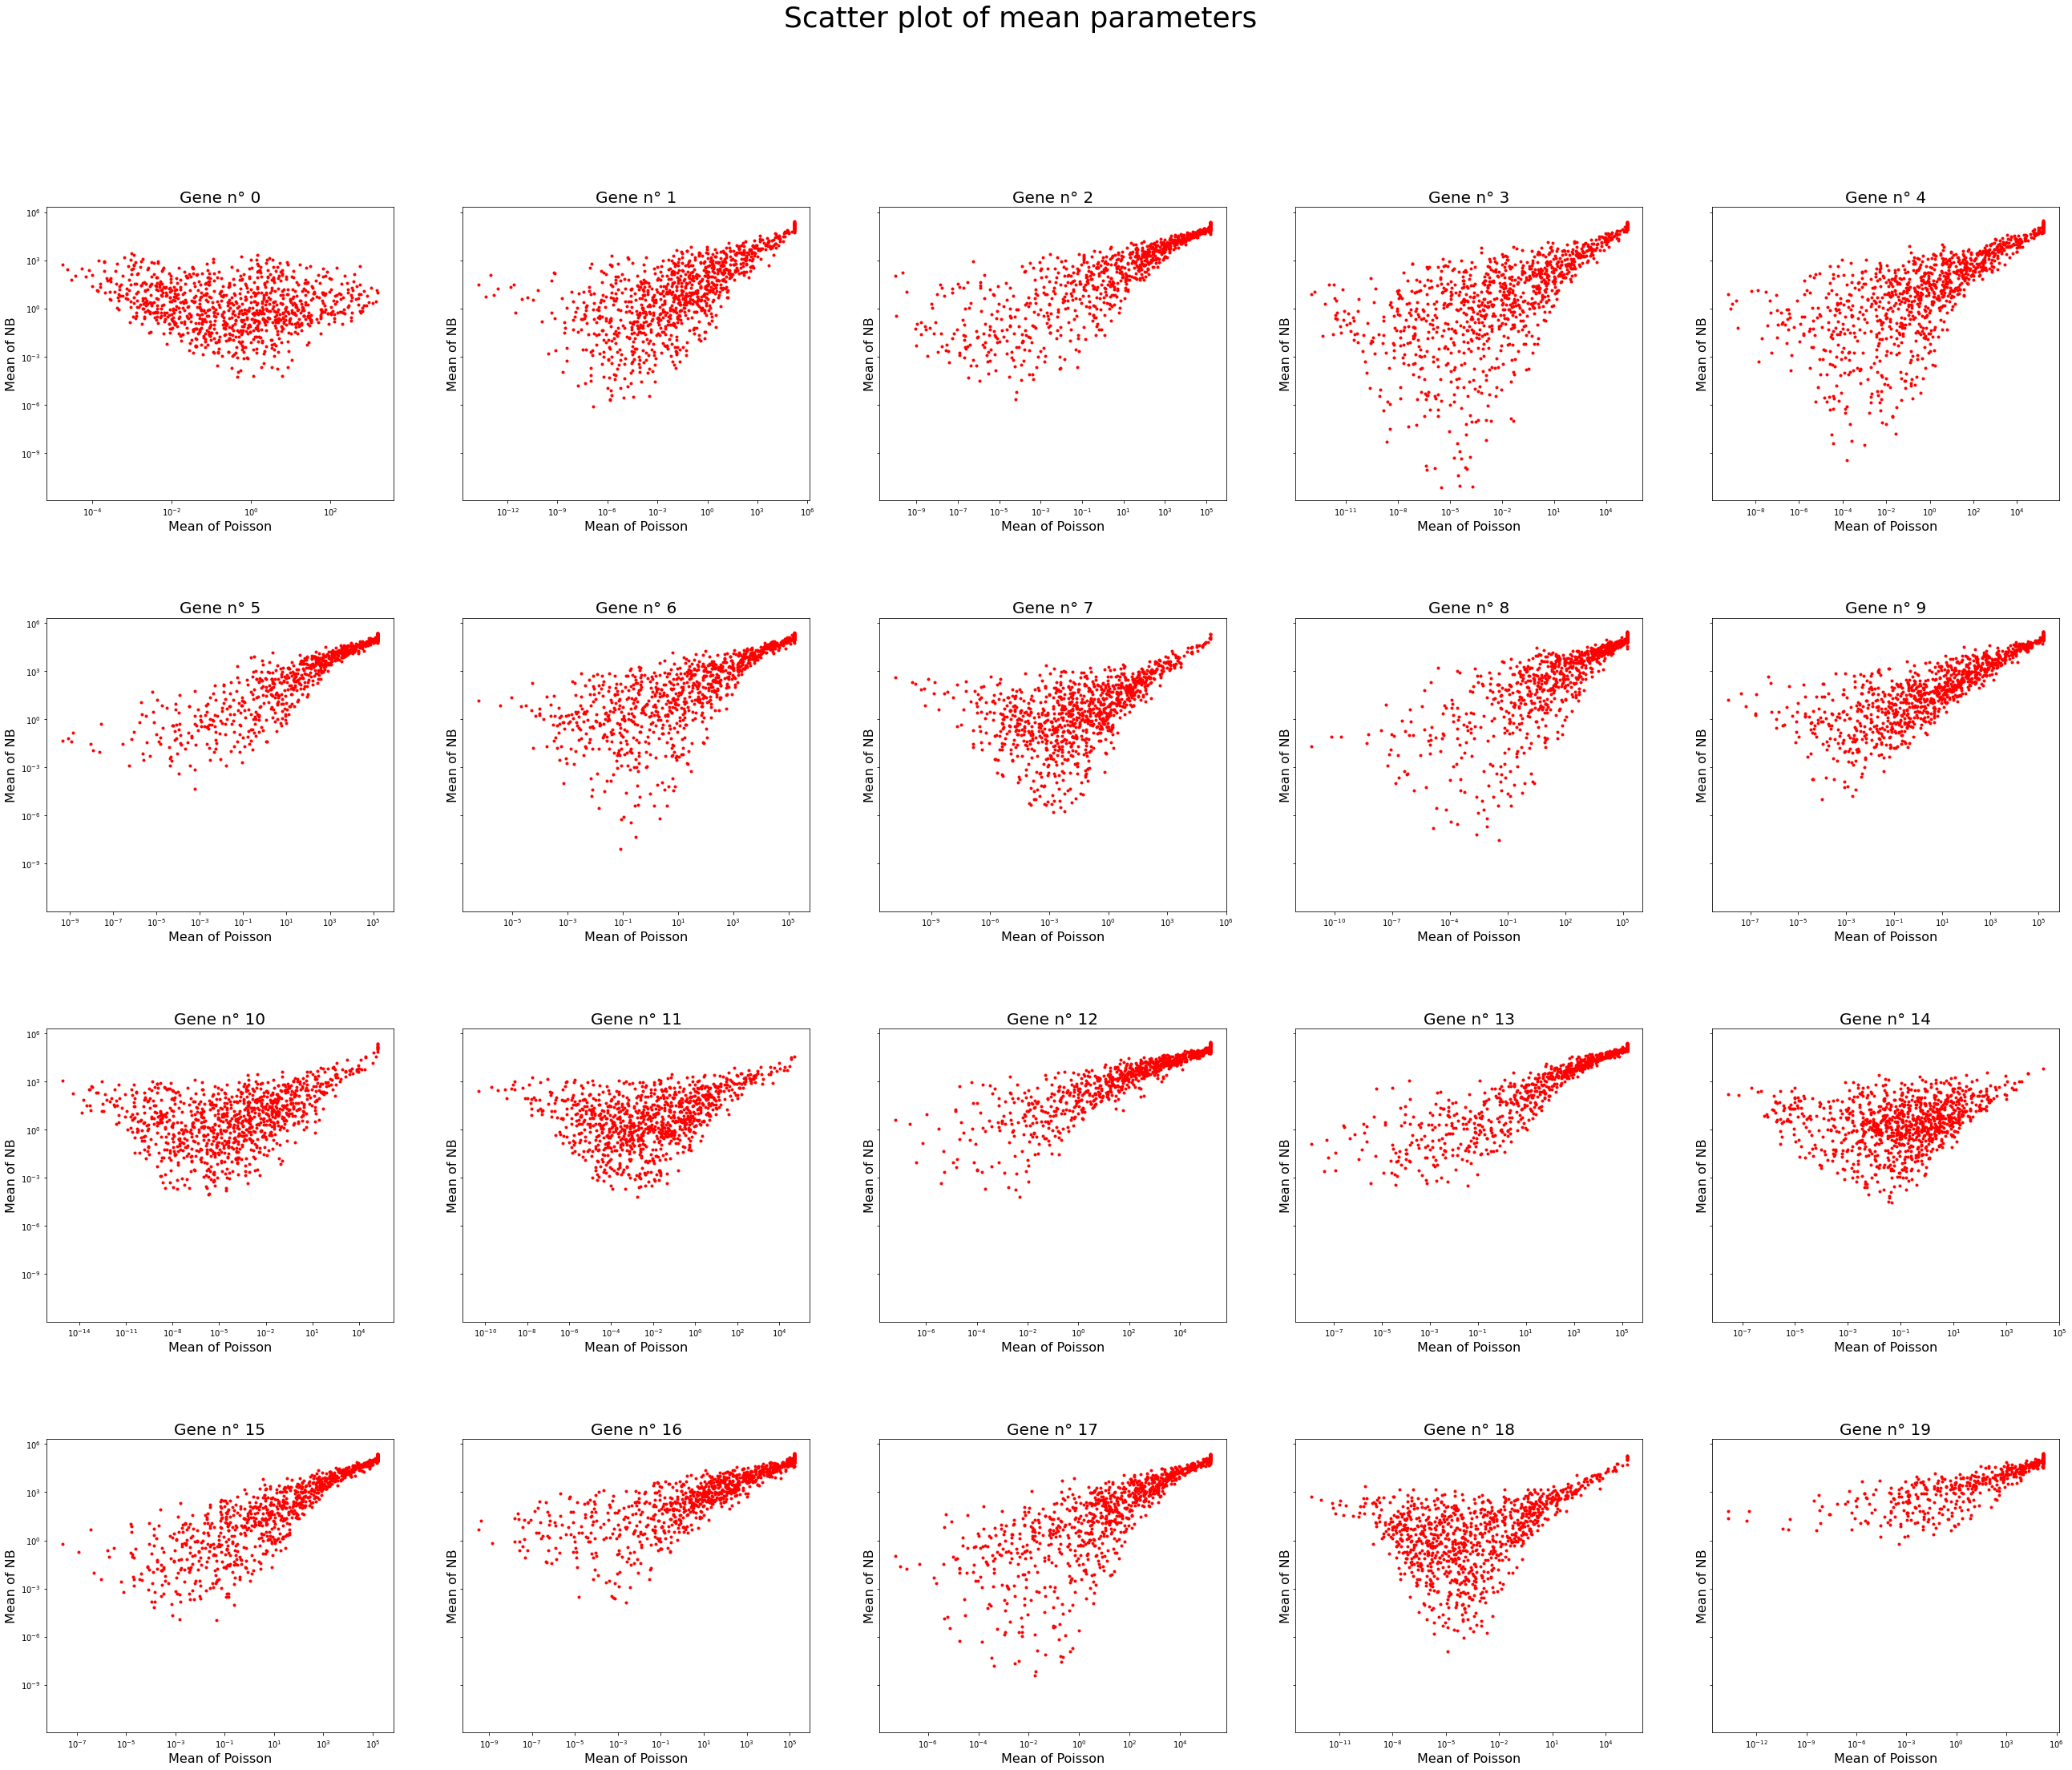

In [203]:
plot_scatter_mean(mu[:, :20], imputed_values[:, :20], 20, 'red')

### PPC 1: Goodness of fit


To assess the goodness or the lack of fit of our model to the observation data, we will sample from the posterior predictive distribution. These new samples $x^{rep}$ can be interpreted as replications of the gene expression data at the leaves. Precisely, the exact interpretation would be: "If we have already observed x (observed data at the leaves)" $x^{rep}$ would be the data observed right after.

The posterior predictive density is defined as:

$$
p(x^{rep}|x) = \int{p(x^{rep}|z)p(z|x)dz}
$$

because $p(x^{rep}|z) = p(x^{rep}|z, x)$

In a variational framework, the sampling is done by repeating these two steps:
1.  sample $ z \sim q(z|x) $ from the posterior variational distribution
2.  sample $ x^{rep} \sim p(x^{rep}|z) $

In practice, in the scVI framework, once the model and the neural networks are fitted to the dataset (we need the dispersion parameter to sample from the NB distribution, which is derived by variational approximation), we can go through the dataset again (by batche) in inference mode. for each batche $x$, we make a full forward pass and obtain the reconstructed mean and dispersion parameter of the negative binomial, that we subsequently use to sample from a Negative Binomial to generate the "replicated samples".

One straightforward way, to measure the discrepancy between model and data is to simply plot the histograms of the observed and replicated data.

In [183]:
#samples = full_posterior.generate(n_samples=2, 
#                                  batch_size=64)

#rep_samples = samples[0]
#rep_samples.shape, len(glm_samples)

#### Bayesian p-value and test quantities

We measure discrepeancy between the model and the observed data by defining __test quanitities__. A test quantity or discrepeancy measure $T(x, z)$ is a scalar summary of parameters and data that is used as a standard when comparing data to predictive simulations (~ test statistic in frequentist stats)

__Posterior Predictive p-values__: To evaluate the fit of the posterior distribution of a Bayesian model, we can compare the observed data to the posterior predictive distribution. In the Bayesian approach, test quantities can be functions of the unknown parameters as well as data because the test quantity is evaluated over draws from the posterior distribution of the latent parameters. The Bayesian p-value is defined as the probability that the replicated data could be more extreme than the observed data, as measured by the test quantity.
 The Bayesian p-value is defined as the probability that the replicated data could be more extreme than the observed data, as measured by the test quantity:
 
$$
p_B = Pr(T(x^{rep}, z) \geq T(x, z) | x)
$$

In constrast, frequentist p-value would be

$$
p_f = Pr(T(x^{rep}) \geq T(x) | z)
$$

Then:

$$
p_B = \int\int \mathbb{1}_{T(x^{rep}, z) \geq T(x, z) }p(x^{rep}|z)p(z|x)dx^{rep}dz
$$

In practice:
1.  sample $ z \sim q(z|x) $ from the posterior variational distribution
2.  sample $ x^{rep} \sim p(x^{rep}|z) $
3. Compute $T(x^{rep}, z)$ and $T(x, z)$ and check if $T(x^{rep}, z) \geq T(x, z) $
4. Compute the proportion

We must decide the form of the statistic $T$. On the previous plots, we can observe that our treeVAE model is able to replicate GE observations for highly expressed gense (cf genes $0,1,17,18...$). However we can notice that for genes that showcase low level of expressions (cf genes $2,9,19...$), though the replicated data shows relatively lower levels of expressions, it still remains significantly higher than the levels of expresssion of real data.

idea for T for each gene $g=1...G$:

$$
T(x, z) = max(x_i^{g}\mathbb{1}_{0 \leq x_i^{g} \leq 20})_{i=1...n} 
$$

In [ ]:
# Bayesian p-value
p_B = 0
S = rep_samples.shape[2]
obs_samples = leaves_X
rep_samples.shape, obs_samples.shape
for i in range(S):
    for j in range(g):
        x_rep = rep_samples[:, j, i]
        x_obs = obs_samples[:, ]
        max_x_obs = np.max(x_obs[x_obs <= 20].ravel()) #np.max(x_obs.ravel()) 
        max_x_rep = np.max(x_rep[x_rep <= 20].ravel()) #np.max(x_rep.ravel())         
        if max_x_rep >= max_x_obs:
            p_B += 1
            
p_B /= S*g
print("Bayesian p-value {}:".format(p_B))

### Kolmogorov-Smirnov test (distribution agnostic).

#### Empirical  Cumulative Distribution

In [ ]:
plot_ecdf_ks(glm_samples, rep_samples, g)

We compute the Kolmogorov-Smirnov statistic on 2 samples. This is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.

The statistic is defined as:

$$
D^{KS} = sup_{x}|F_0(x) - F_{data}(x)|
$$

***Null Hypothesis*** ($H_0$): the generated data comes from the a Poisson distribution.

(In our model we know that each $x^{rep}_{ng} \sim NegativeBinomial(l_n w_{ng})$ so we want to check if the samples generated from this distribution are close enough to a Poisson))

In [ ]:
df_pvalues = ks_pvalue(g, glm_samples, rep_samples)

df_pvalues.head(20)

### PPC3: Missing value imputation at internal node

posterior predictive density on the latent space

In [204]:
#internal_node = '0|0|0|0|0|0|0|0|0|0|0|3|4|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|3|0|0|0|-|-|-|0|0'
#internal_node = "0|0|0|0|5|10|0|0|0|2|0|0|0|0|0|0|0|0|2|0|0|0|0|0|0|0|0|0|0"
internal_node = '5'

mu_var, nu = vae.posterior_predictive_density(internal_node)
print("inferred paramater --> mu: {}".format(mu_var))
print("inferred paramater --> nu: {}".format(nu))

inferred paramater --> mu: tensor([ 1.5551, -0.1405, -0.7332,  0.4604,  0.6870], dtype=torch.float64)
inferred paramater --> nu: 0.32832071861029044


In [205]:
leaves = vae.tree.get_leaves()
leaf = vae.tree.search_nodes(name=leaves[0].name)[0]
leaf.nu, leaf.mu

(0, tensor([ 1.6180, -6.5493,  2.5740,  0.0806,  1.4561], dtype=torch.float64))

#### Sampling from posterior predictive distribution

To impute missing gene expression value at an unobserved internal node, we need to sample from the posterior predictive distribution. However, this time, since this data has not been observed during training, we will need to sample a latent representation of the query node. To do so, we will use the __message passing__ algorithm for posterior predictive inference.

Formally, let $x^*$ an unobserved internal node. Here we change the notation to make a clear separation with the previous notation $x^{rep}$, what we called the __replicated data__ at the temrinal nodes. we want to estimate the conditonal. Again, we note $x$ the observed data at the terminal nodes.:

$$
p(x^*|x) = \int p(x^*, z^*, z|x) dz^* dz \\ 
= \int p(x^*, z^*, z|x) dz^* dz \\
= \int p(x^*|z^*, z, x) p(z^*, z| x) dz^* dz \\
= \int p(x^*|z^*) p(z^*| z) p(z|x) dz^* dz \\
$$

in practice, sampling $x^*$ from $p(x^*|x)$ is equivalent to:
1. Sampling $ z \sim p(z|x)$ i.e encoding the observed data with the fitted **treeVAE** on the [Cassiopea + GeneExpression dataset]
2. Sampling $z^* \sim p(z^*|z)$ i.e inferring $\mu^*$ and $\nu^*$ with the message passing algorithm and sampling a latent vector from the multivariate normal distribution $\mathcal{N}(\mu^*, \nu^*)$
3. Sampling $x^* \sim p(x^*|z = z^*)$ i.e decoding $z^*$ with the fitted VAE.

Using the message passing adds training constraints, typically we cannot use mini-batches. To initialize the message passing, we need all latent space representations of observed gene expression value, thus we need to encode to whole dataset during step 1.

#### MV Mean imputation at internal nodes

In [206]:
imputed_mean = {}

for n in tree.traverse('levelorder'):
    if not n.is_leaf():
        imputed_mean[n.name] = full_posterior.imputation_internal(query_node=n.name,
                                                                 give_mean=True,
                                                                 library_size=10000)[0]

In [207]:
internal_mean = np.array([t.detach().cpu().numpy() for t in list(imputed_mean.values())])
internal_mu.shape, internal_mean.shape

((999, 100), (999, 100))

Scatter Plot

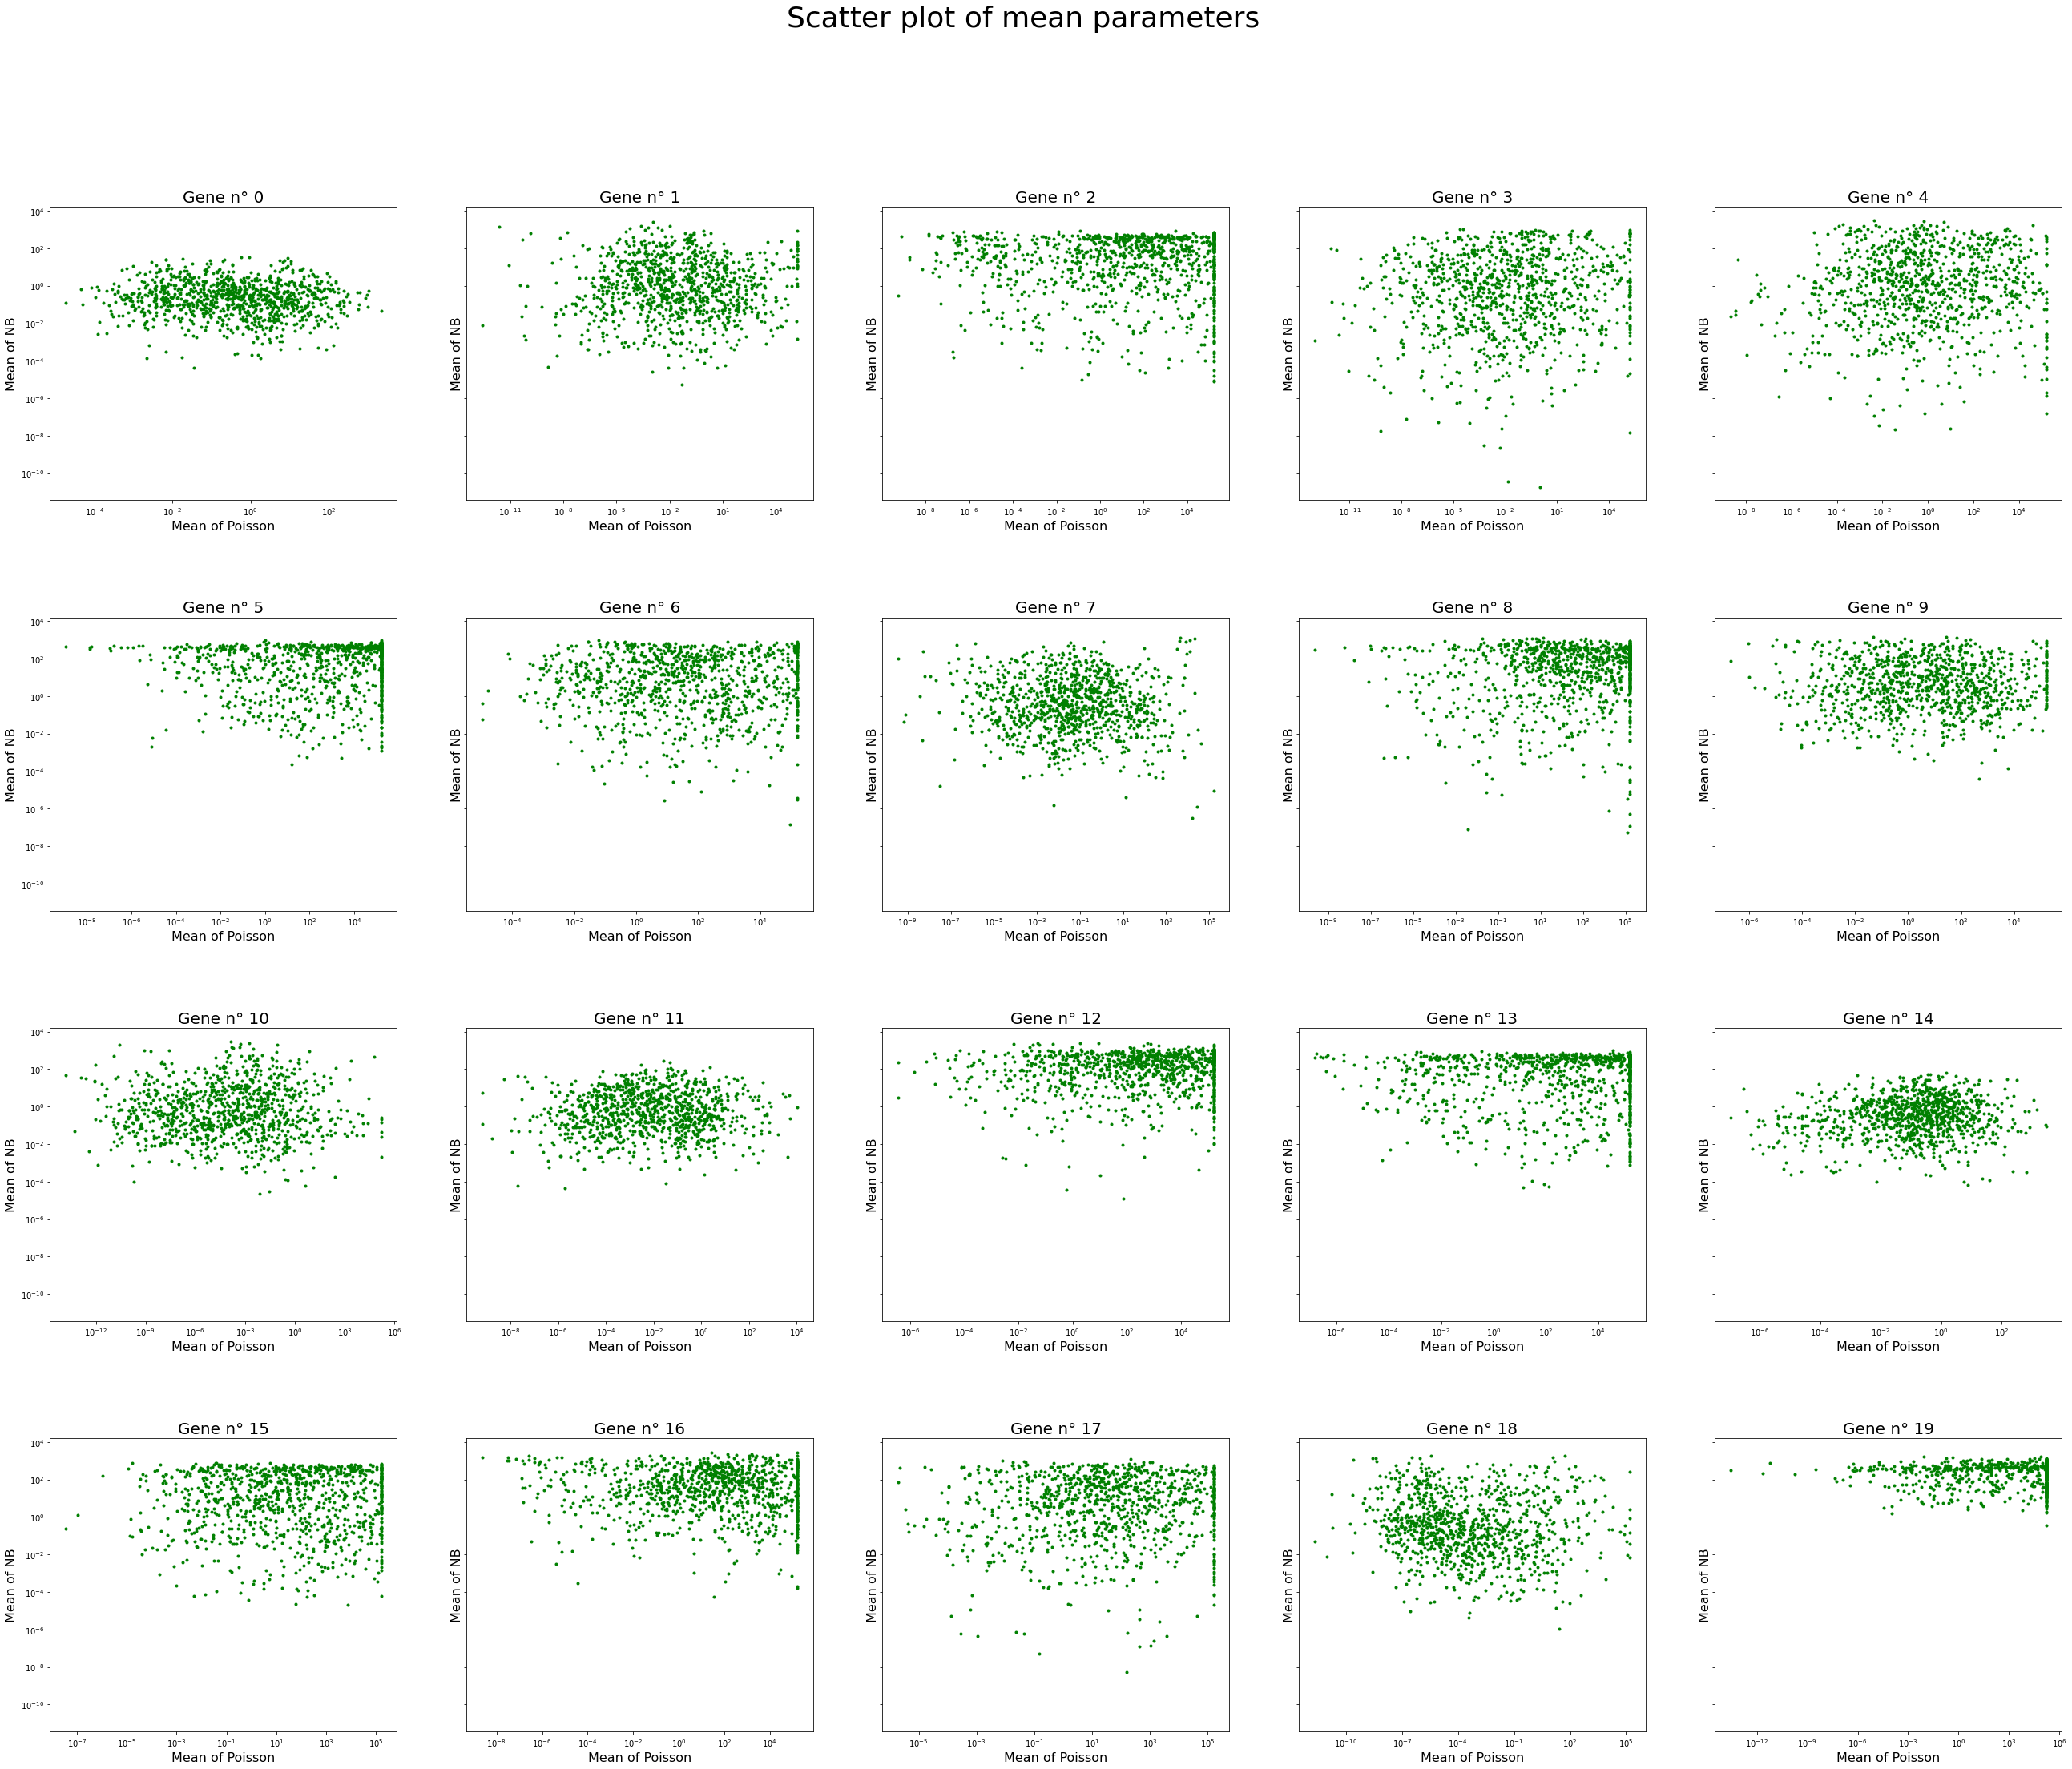

In [208]:
plot_scatter_mean(internal_mu[:, :20], internal_mean[:, :20], 20, 'green')

#### MV imputation at all internal nodes

Imputation of all internal nodes

In [265]:
empirical_l = 10000
imputed = {}
imputed_gt = {}

for n in tree.traverse('levelorder'):
    if not n.is_leaf():
        imputed[n.name] = full_posterior.imputation_internal(n.name,
                                                            give_mean=False,
                                                            library_size=empirical_l,
                                                            averaging=False)[0]
        imputed_gt[n.name] = glm.X[n.index]

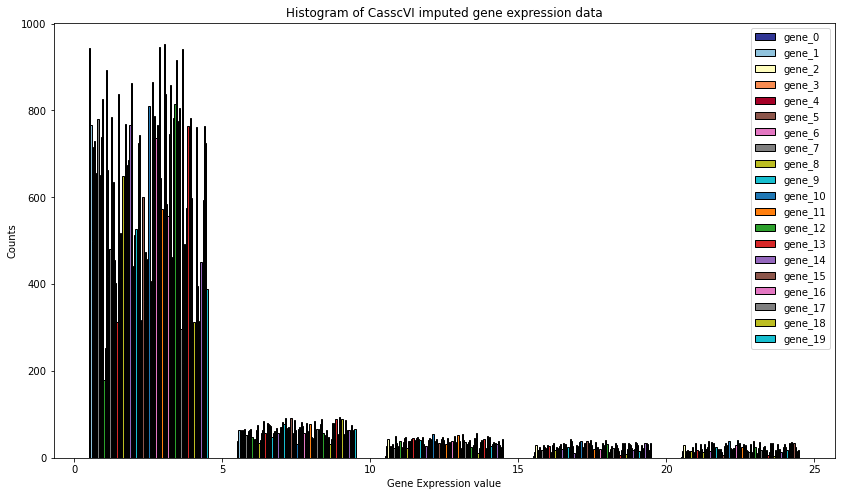

In [267]:
imputed_X = [x for x in imputed.values()]
imputed_X = np.array(imputed_X).reshape(-1, glm.X.shape[1])
plot_histograms(imputed_X, "Histogram of CasscVI imputed gene expression data")

##### Baseline 1: Unweighted Average of gene expression in Clade

The simple idea here is to impute the value of an internal node, with the (un)weighted average of the gene expression values of the leaves, taking the query internal node as the root of the subtree.

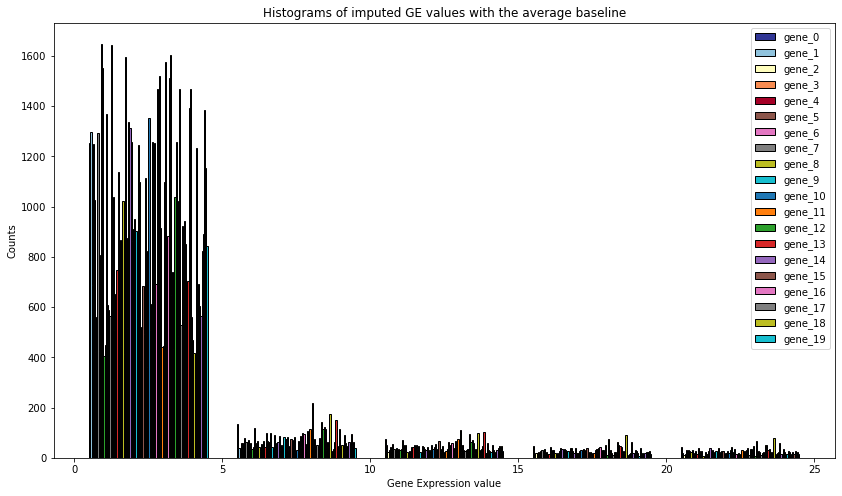

In [334]:
weighted = True
imputed_avg = avg_weighted_baseline(tree, True, glm.X)

#get internal nodes
avg_X = np.array([x for x in imputed_avg.values()]).reshape(-1, glm.X.shape[1])
internal_avg_X, _, _ = get_internal(avg_X, glm.mu, tree)
plot_histograms(avg_X,
               'Histograms of imputed GE values with the average baseline')

In [335]:
internal_avg_X.flatten()

array([4.60000e+01, 9.40100e+03, 5.13840e+04, ..., 3.92000e+02,
       0.00000e+00, 1.60363e+05])

#### Baseline 2: (Un)weighted Average of decoded latent vectors, with scVI

We use the same averaging of the subtrees leaves in **Baseline 1**, only this time, the gene expression data is recovered with scVI

In [213]:
# anndata
gene_dataset = GeneExpressionDataset()
gene_dataset.populate_from_data(leaves_X)

[2021-01-25 10:57:15,918] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-01-25 10:57:15,919] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]


training: 100%|██████████| 1000/1000 [02:08<00:00,  7.77it/s]


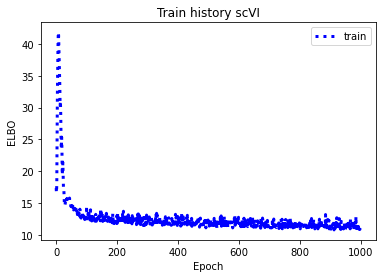

In [214]:
n_epochs = 1000

vae_scvi = VAE(gene_dataset.nb_genes,
                  n_batch=cas_dataset.n_batches * use_batches,
                  n_hidden=128,
                  n_layers=1,
                  reconstruction_loss='poisson',
                  n_latent=glm.dim)

trainer_scvi = UnsupervisedTrainer(model=vae_scvi,
                              gene_dataset=gene_dataset,
                              train_size=1.0,
                              use_cuda=use_cuda,
                              frequency=1
                            ,
                              n_epochs_kl_warmup=500)

# train scVI
trainer_scvi.train(n_epochs=n_epochs, lr=1e-3) 
                                        
elbo_train_scvi = trainer_scvi.history["elbo_train_set"]
x = np.linspace(0, 100, (len(elbo_train_scvi)))
plt.plot(np.log(elbo_train_scvi), 
         label="train", color='blue',
         linestyle=':',
         linewidth=3 )
plt.xlabel('Epoch')
plt.ylabel("ELBO")
plt.legend()
plt.title("Train history scVI")
plt.show()

In [215]:
#plot_scatter_mean(mu[:, :20], imputed_scvi[:, :20], 20, 'blue')

Postetior + Imputation

In [288]:
scvi_posterior = trainer_scvi.create_posterior(model=vae_scvi,
                                              gene_dataset=gene_dataset,
                                              )
imputed_scvi = scvi_baseline(tree, scvi_posterior, True)

CascVI average imputation

In [289]:
imputed_cascvi = scvi_baseline(tree, full_posterior, True)

## 5. Evalutation

***CPM Normalization (good for sample-sample comparison)***

In [463]:
internal_scvi_X = np.vstack([x for x in list(imputed_scvi.values())])
internal_cascvi_X = np.vstack([x for x in list(imputed_cascvi.values())])
internal_scvi_X.shape, internal_cascvi_X.shape

((999, 100), (999, 100))

In [464]:
from sklearn.preprocessing import normalize

norm_internal_X = sc.pp.normalize_total(AnnData(internal_X), target_sum=1e4, inplace=False)['X'] 
norm_scvi_X = sc.pp.normalize_total(AnnData(internal_scvi_X), target_sum=1e4, inplace=False)['X']
norm_avg_X = sc.pp.normalize_total(AnnData(internal_avg_X), target_sum=1e4, inplace=False)['X']
norm_imputed_X = sc.pp.normalize_total(AnnData(imputed_X), target_sum=1e4, inplace=False)['X']
norm_cascvi_X = sc.pp.normalize_total(AnnData(internal_cascvi_X), target_sum=1e4, inplace=False)['X']

norm_internal_X.shape

(999, 100)

### I. Sample-Sample

***No Normalization***

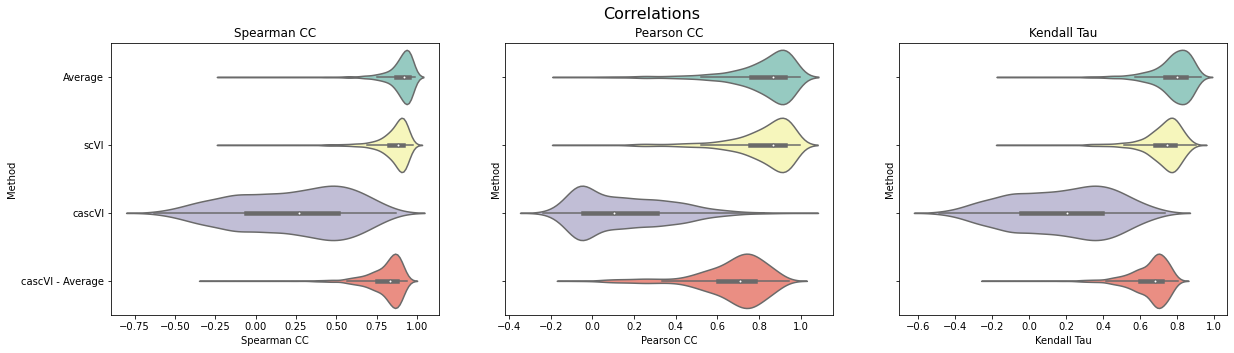

In [465]:
data = [internal_X.T, imputed_X.T, internal_avg_X.T ,internal_scvi_X.T, internal_cascvi_X.T]
df1 = correlations(data, 'None', True)
df1.head(5)
plt.show()

***2. Sample-Sample correlation (With ScanPy Normalization)***

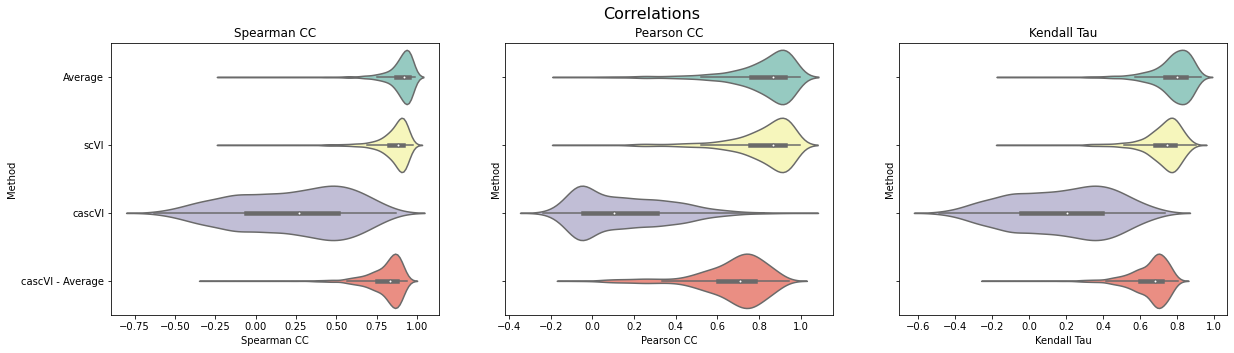

In [466]:
data = [norm_internal_X.T, norm_imputed_X.T, norm_avg_X.T ,norm_scvi_X.T, norm_cascvi_X.T]
df2 = correlations(data, 'None', True)
df2.head(5)
plt.show()

### II. Gene-Gene Correlations

***1. Gene-Gene correlation (without Normalization)***

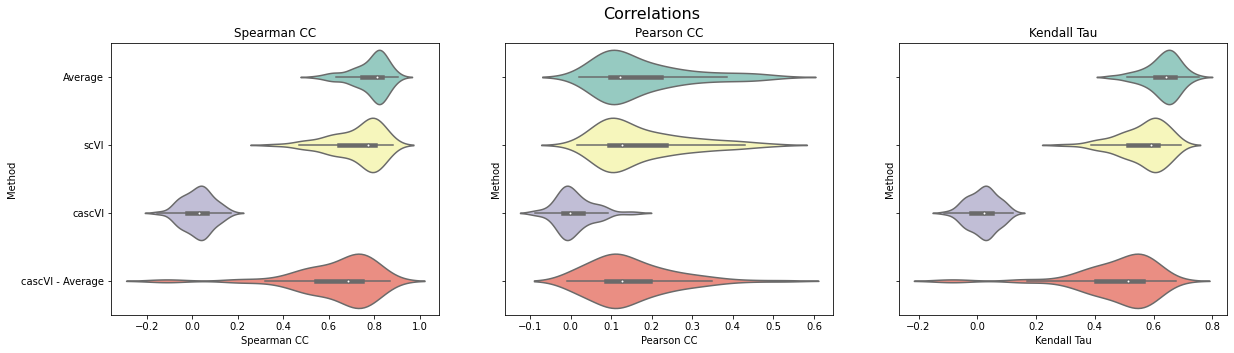

In [467]:
data = [internal_X, imputed_X, internal_avg_X ,internal_scvi_X, internal_cascvi_X]
df3 = correlations(data, 'None', True)
df3.head(5)
plt.show()

***2. Gene-Gene correlation (With Normalization)***

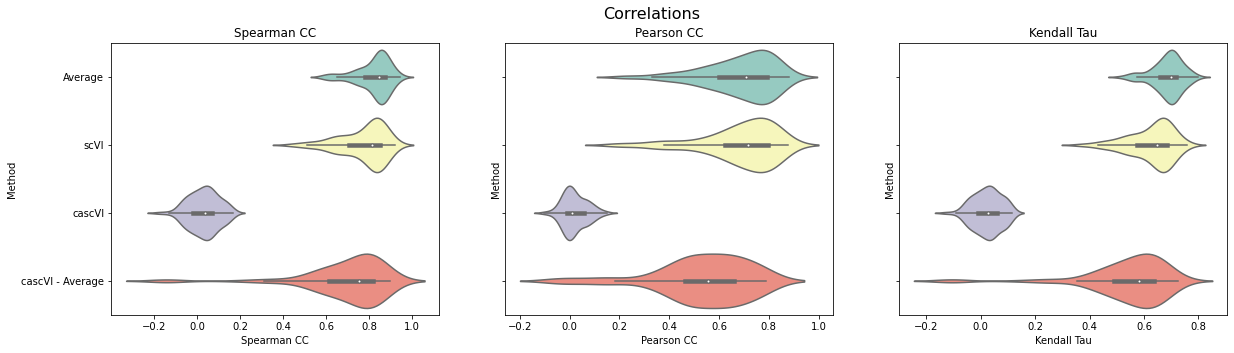

In [468]:
data = [norm_internal_X, norm_imputed_X, norm_avg_X ,norm_scvi_X, norm_cascvi_X]
df4 = correlations(data, 'None', True)
df4.head(5)
plt.show()

***3. Gene-Gene correlation (With Rank Normalization)***

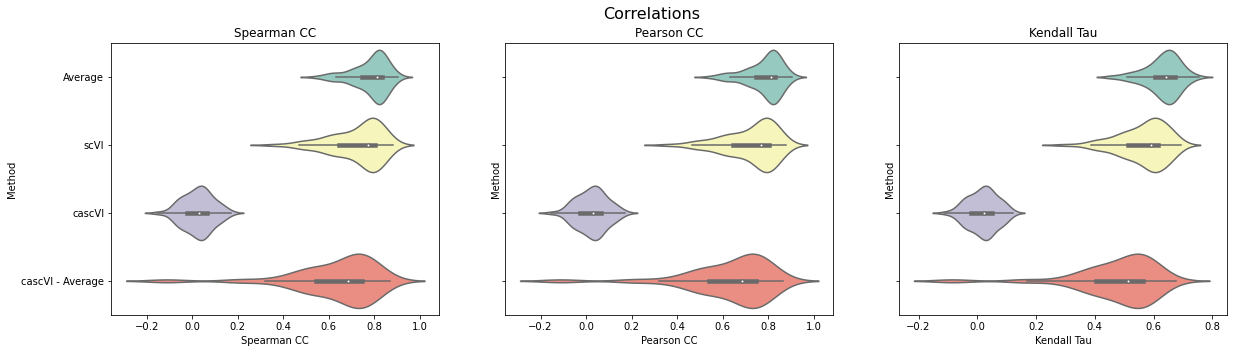

In [469]:
data = [internal_X, imputed_X, internal_avg_X ,internal_scvi_X, internal_cascvi_X]
df5 = correlations(data, 'rank', True)
df5.head(5)
plt.show()

***Table Summary***

In [476]:
columns = ["Method", "Spearman CC", "Pearson CC", "Kendall Tau"]
data = [df1, df2, df3, df4, df5]

tables = [[] for i in range(len(data))]

#task = ["Sample-Sample (None)", "Sample-Sample (CPM)", "Gene-Gene (None)", 
           #"Gene-Gene(CPM)", "Gene-Gene (Rank)" ]

for (df, t) in zip(data, tables):
    for m in np.unique(df.Method):
        sub_df = np.round(df[df['Method'] == m].mean(), decimals=3)
        t.append([m, sub_df['Spearman CC'], sub_df['Pearson CC'], sub_df['Pearson CC']])
        
# Create and style Data Frames
df_table1 = pd.DataFrame(tables[0], columns=columns)
df_table2 = pd.DataFrame(tables[1], columns=columns)
df_table3 = pd.DataFrame(tables[2], columns=columns)
df_table4 = pd.DataFrame(tables[3], columns=columns)
df_table5 = pd.DataFrame(tables[4], columns=columns)

In [477]:
print(" >>> Sample-Sample | No Normalization <<<")
df_table1.head()

 >>> Sample-Sample | No Normalization <<<


,Method,Spearman CC,Pearson CC,Kendall Tau
0,Average,0.886,0.811,0.811
1,cascVI,0.227,0.147,0.147
2,cascVI - Average,0.797,0.669,0.669
3,scVI,0.850,0.813,0.813


In [478]:
print(">>> Sample-Sample | CPM Normalization <<<")
df_table2.head()

>>> Sample-Sample | CPM Normalization <<<


,Method,Spearman CC,Pearson CC,Kendall Tau
0,Average,0.886,0.811,0.811
1,cascVI,0.227,0.147,0.147
2,cascVI - Average,0.797,0.669,0.669
3,scVI,0.850,0.813,0.813


In [479]:
print(">>> Gene-Gene | No Normalization <<<")
df_table3.head()

>>> Gene-Gene | No Normalization <<<


,Method,Spearman CC,Pearson CC,Kendall Tau
0,Average,0.782,0.173,0.173
1,cascVI,0.024,0.009,0.009
2,cascVI - Average,0.625,0.146,0.146
3,scVI,0.721,0.173,0.173


In [480]:
print(">>> Gene-Gene | CPM Normalization <<<")
df_table4.head()

>>> Gene-Gene | CPM Normalization <<<


,Method,Spearman CC,Pearson CC,Kendall Tau
0,Average,0.820,0.679,0.679
1,cascVI,0.030,0.019,0.019
2,cascVI - Average,0.689,0.532,0.532
3,scVI,0.770,0.680,0.680


In [481]:
print(">>> Gene-Gene | Rank Normalization <<<")
df_table5.head()

>>> Gene-Gene | Rank Normalization <<<


,Method,Spearman CC,Pearson CC,Kendall Tau
0,Average,0.782,0.782,0.782
1,cascVI,0.024,0.024,0.024
2,cascVI - Average,0.625,0.625,0.625
3,scVI,0.721,0.721,0.721


**QQ PLOT**

In [460]:
import numpy as np 
import statsmodels.api as sm
import pylab as py 

In [461]:
sm.graphics.gofplots.qqplot_2samples(data1=norm_internal_X,
                                     data2=norm_avg_X,
                                     xlabel="Quantiles of Average Baseline",
                                    ylabel="Quantiles of groundtruth data",
                                    )

sm.graphics.gofplots.qqplot_2samples(data1=norm_internal_X,
                                     data2=norm_imputed_X,
                                     xlabel="Quantiles of CascVI",
                                    ylabel="Quantiles of groundtruth data")

sm.graphics.gofplots.qqplot_2samples(data1=norm_internal_X,
                                     data2=norm_scvi_X,
                                     xlabel="Quantiles of scVI baseline",
                                    ylabel="Quantiles of groundtruth data")

sm.graphics.gofplots.qqplot_2samples(data1=norm_internal_X,
                                     data2=norm_cascvi_X,
                                     xlabel="Quantiles of cascVI -avg baseline",
                                    ylabel="Quantiles of groundtruth data")

py.show() 

AttributeError: module 'statsmodels.graphics.api' has no attribute 'gofplots'

In [462]:
sm.graphics.gofplots.qqplot_2samples(data1=adata_internal_X.T,
                                     data2=adata_avg_X.T,
                                     xlabel="Quantiles of Average Baseline",
                                    ylabel="Quantiles of groundtruth data")

sm.graphics.gofplots.qqplot_2samples(data1=adata_internal_X.T,
                                     data2=adata_imputed_X.T,
                                     xlabel="Quantiles of CascVI",
                                    ylabel="Quantiles of groundtruth data")

sm.graphics.gofplots.qqplot_2samples(data1=adata_internal_X.T,
                                     data2=adata_scvi_X.T,
                                     xlabel="Quantiles of scVI baseline",
                                    ylabel="Quantiles of groundtruth data")

sm.graphics.gofplots.qqplot_2samples(data1=adata_internal_X.T,
                                     data2=adata_cascvi_X.T,
                                     xlabel="Quantiles of cascVI -avg baseline",
                                    ylabel="Quantiles of groundtruth data")

py.show() 

AttributeError: module 'statsmodels.graphics.api' has no attribute 'gofplots'

### Visualizing patterns with iToL (gene 9)

In [ ]:
leaves = tree.get_leaf_names()
import pandas as pd 

gene = 299
node_names = []

ge = []
ge_gt = []
ge_avg = []
ge_scvi = []

for n in tree.traverse('levelorder'):
    if n.is_leaf():
        ge.append(int(glm.X[n.index][gene]))
        ge_scvi.append(int(glm.X[n.index][gene]))
        ge_avg.append(int(glm.X[n.index][gene]))
    else:
        ge.append(int(imputed[n.name][gene]))
        ge_scvi.append(int(imputed_scvi[n.name][gene]))
        ge_avg.append(int(imputed_avg[n.name][gene]))
    node_names.append(n.name)
    ge_gt.append(int(glm.X[n.index][gene]))

Extract leaves data

In [ ]:
ge_leaves, leaves_names = [], []
for data, name in zip(ge_gt, node_names):
    if name in leaves:
        ge_leaves.append(data), leaves_names.append(name)
        
len(ge_leaves)

Sotrie in Pandas dataframes

In [ ]:
df = pd.DataFrame(ge,
                  index = node_names, 
                  columns =['GE-1-imputed']
                 )

df_leaves = pd.DataFrame(ge_leaves,
                  index = leaves_names, 
                  columns =['GE-1-leaves']
                 )

df_gt = pd.DataFrame(ge_gt,
                  index = node_names, 
                  columns =['GE-1-groundtruth']
                 )

df_avg =  pd.DataFrame(ge_gt,
                  index = node_names, 
                  columns =['GE-1-avg']
                 )

df_scvi = pd.DataFrame(ge_scvi,
                  index = node_names, 
                  columns =['GE-1-scvi']
                 )



df.head(5), df_leaves.head(5), df_gt.head(5), df_avg.head(5), df_scvi.head(5)

In [ ]:
df.to_csv('/Users/khalilouardini/Desktop/projects/scVI/scvi/notebooks/plots/GE-1-imputed.txt',
          sep='\t'
         )

df_leaves.to_csv('/Users/khalilouardini/Desktop/projects/scVI/scvi/notebooks/plots/GE-1-leaves.txt',
          sep='\t'
         )

df_gt.to_csv('/Users/khalilouardini/Desktop/projects/scVI/scvi/notebooks/plots/GE-1-gt.txt',
          sep='\t'
            )

df_avg.to_csv('/Users/khalilouardini/Desktop/projects/scVI/scvi/notebooks/plots/GE-1-avg.txt',
          sep='\t'
            )

df_scvi.to_csv('/Users/khalilouardini/Desktop/projects/scVI/scvi/notebooks/plots/GE-1-scvi.txt',
          sep='\t'
            )


### Variance Analysis

In [ ]:
qz_v_norm = full_posterior.empirical_qz_v(
                                    n_samples=1000,
                                    norm=True)

In [ ]:
qz

In [ ]:
var = []
i = 0

for n in tree.traverse('levelorder'):
    if not n.is_leaf():
        z = full_posterior.get_latent(give_mean=False)[0]
        _, v_nu = vae.posterior_predictive_density(query_node=n.name, 
                                                  evidence=z) 
        
        var.append(str(np.around(a=v_nu,
                             decimals=3))
                  )
    else:
        idx = leaves_idx.index(n.index)
        #var.append(np.format_float_scientific(int(qz_v_norm[idx])))
        var.append(str(np.around(a=qz_v_norm[idx],
                                 decimals=3))
                                )

In [ ]:
df_var = pd.DataFrame(var,
                  index = node_names, 
                  columns =['variance']
                 )

df_var.to_csv('/Users/khalilouardini/Desktop/projects/scVI/scvi/notebooks/plots/variance.txt',
          sep='\t'
            )
